In [1]:
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
PATH = Path('data')

from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,accuracy_score
from sklearn.model_selection import GridSearchCV

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [33]:
def date_breakdown(df,col):
    df[f'{col}_year']=df[col].dt.year
    df[f'{col}_month']=df[col].dt.month
    df[f'{col}_day']=df[col].dt.day
    df[f'{col}_dayofweek']=df[col].dt.dayofweek
    df[f'{col}_weekofyear'] = df[col].dt.weekofyear
    return df
def get_data():
    df= pd.read_csv(PATH/'employee_retention_data.csv',parse_dates=['join_date', 'quit_date'])
    for col in ['join_date','quit_date']:
        df = date_breakdown(df,col)
    df['quit'] = ~df.quit_date.isnull()
    df['employed_delta'] = (df.quit_date - df.join_date) / np.timedelta64(1, 'M')
    df.drop(df[df.seniority>=90].index,inplace=True)
    df = df.sort_values('join_date').reset_index(drop=True)
    return df
def prepare_label(df):
    delta=df.loc[df.quit,'employed_delta']
    new_label=pd.Series(np.zeros(len(df)))
    new_label[delta[delta <16].index]=1 # quit after aprox 1 year
    new_label[delta[delta.between(16,29.999)].index]=2 # quit after 2 years
    new_label[delta[delta >30].index]=3 # quit after >2 years
    return new_label.astype(np.int8)
def prepare_data_RF(employment_time,dummies=True,max_year=2015):
    df = get_data()
    df['class_label'] = prepare_label(df)
    drop_col=['employee_id','join_date',
              'quit_date','quit_date_year','quit_date_month','quit_date_day','quit_date_dayofweek','quit_date_weekofyear',
              'quit','employed_delta']
    df.drop(drop_col,axis=1,inplace=True)
            
    # filter class label based on employment_time
    df.drop(df[df.join_date_year > max_year-employment_time].index,inplace=True)
    if employment_time>1:
        df.drop(df[df.class_label.between(1,employment_time-1)].index,inplace=True)
    df.loc[df.class_label!=employment_time,'class_label'] = 0
    
    df = df.reset_index(drop=True)
    y=df.class_label.astype(np.int8)
    
    # convert type
    cat_cols=['company_id','dept','join_date_year','join_date_month','join_date_day',
            'join_date_dayofweek','join_date_weekofyear']
    for col in df.columns.values:
        if col in cat_cols: df[col] = df[col].astype('category')
        else: df[col] = df[col].astype(np.int32)
    
    # dummies
    if dummies:
        df = pd.get_dummies(df,columns=cat_cols[:2])
    return df.drop('class_label',axis=1), y
def get_headcount():
    df = get_data()
    
    dates=pd.date_range('2011-01-24','2015-12-23').values
    companies=sorted(df.company_id.unique())
    
    df_headcount=pd.DataFrame(list(product(*[dates,companies])),columns=['date','company_id'])
    df_headcount.date = pd.to_datetime(df_headcount.date)
    df_join=df.groupby(['join_date','company_id']).size().reset_index(name='join_count')
    df_quit = df.groupby(['quit_date','company_id']).size().reset_index(name='quit_count')
    df_headcount = df_headcount.merge(df_join,how='left',
                                      left_on=['date','company_id'],
                                      right_on=['join_date','company_id'])
    df_headcount = df_headcount.merge(df_quit,how='left',
                                      left_on=['date','company_id'],
                                      right_on=['quit_date','company_id'])
    df_headcount.drop(['join_date','quit_date'],axis=1,inplace=True)
    df_headcount.fillna(0,inplace=True)
    
    df_headcount['headcount'] = df_headcount.groupby('company_id').join_count.cumsum() \
                                    - df_headcount.groupby('company_id').quit_count.cumsum()
    for col in df_headcount.columns.values[-3:]:
        df_headcount[col] = df_headcount[col].astype(np.int32)
    df_headcount = date_breakdown(df_headcount,'date')
    return df_headcount


def train_rf(X_train,y_train,X_test,y_test,params):
    rf = RandomForestClassifier(random_state=1402,n_jobs=-1,**params)
    rf.fit(X_train,y_train)
    y_pred,y_prob = rf.predict(X_train),rf.predict_proba(X_train)
    print(f'Train acc: {accuracy_score(y_train,y_pred)}. Train lloss: {log_loss(y_train,y_prob)}')
    y_pred,y_prob = rf.predict(X_test),rf.predict_proba(X_test)
    print(f'Test acc: {accuracy_score(y_test,y_pred)}. Test lloss: {log_loss(y_test,y_prob)}')
    return rf
def train_rf_cv(X,y,params,cv):
    for i,(trn_idx,val_idx) in enumerate(cv):
        print(f'Split {i+1}')
        rf=train_rf(X.loc[trn_idx],y[trn_idx],X.loc[val_idx],y[val_idx],params)
    if len(cv)==1:
        return rf
def gridsearch_rf(X,y,params,cv):
    rf = RandomForestClassifier(random_state=1402)
    scoring={'acc':'accuracy','logloss':'neg_log_loss'}
    clf = GridSearchCV(rf,params,scoring=scoring,cv=cv,refit='logloss',n_jobs=-1,return_train_score=False)
    clf.fit(X,y)
    print(f'Best params: {clf.best_params_}')
    print(f'Best logloss: {-1*clf.best_score_}')
    return clf
def get_cv_idxs(X,start=2011,end=2014,last_only=True):
    year = X.join_date_year.astype(np.int32)
    result=[]
    for i in range(start+1,end+1):
        train_idx = year[year <i].index.values
        val_idx = year[year == i].index.values
        result.append((train_idx,val_idx))
    if last_only:
        return np.array([result[-1]])
    return np.array(result)

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels=['Stay','Quit']
    sns.heatmap(cm,cmap='Blues',xticklabels=labels,yticklabels=labels,annot=True,fmt=".0f")
    plt.ylabel('True classes')
    plt.xlabel('Predict classes')

def plot_feature_importances_rf(importances,col_names,figsize=(5,10)):
    dic = {i:j for i,j in zip(col_names,importances)}
    sorted_columns=[]
    sorted_values=[]
    for key in sorted(dic, key=dic.get,reverse=False):
        sorted_columns.append(key)
        sorted_values.append(dic[key])
        
    length = len(importances)    
    plt.figure(figsize=figsize)
    plt.title('Feature Importances')
    plt.barh(range(length),sorted_values[:length],color='lightblue',align='center',height=0.8)
    plt.yticks(range(length),sorted_columns[:length])
    plt.ylim([-1,length])
    plt.tight_layout()


# TODO: relabel independent variable: don't quit / quit after aprox 1 year / quit after approx 2 years (quit after > 2 years???)

# Train: 2011 and 2012, test on 2013

# Pick a simple random forest (few trees) and intepret some of them for some specific record (Jeremy)

In [4]:
temp = get_data()
temp['class_label']= prepare_label(temp)

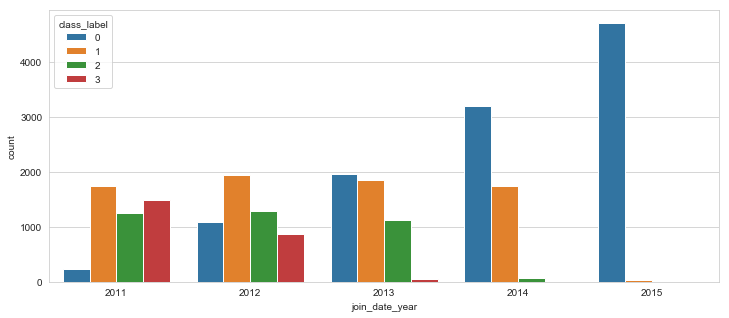

In [5]:
fig,ax = plt.subplots(figsize=(12,5))
sns.countplot(x='join_date_year',data=temp,hue='class_label')

# Stay vs Quit after 1 year

In [4]:
X,y = prepare_data_RF(1)

In [5]:
X.head()

,seniority,salary,join_date_year,join_date_month,join_date_day,join_date_dayofweek,join_date_weekofyear,company_id_1,company_id_2,company_id_3,...,company_id_9,company_id_10,company_id_11,company_id_12,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,18,243000,2011,1,24,0,4,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,74000,2011,1,24,0,4,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8,67000,2011,1,24,0,4,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,11,178000,2011,1,24,0,4,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,17,240000,2011,1,24,0,4,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# base model accuracy score
y_acc=y.value_counts()/ len(y)
y_acc[0]

0.6342123734082021

In [6]:
# base model log loss score
log_loss(y,np.array([y_acc[1]]*len(y)))

0.6566756633829712

We want to determine which factors affect employee churn instead of building a predictive model. We will use cross validation and gridsearch for Random Forest parameter tuning: do a increment timeseries cross validation (train on 2011-validate on 2012, train on 2011 and 2012-validate on 2013 ...)

In [7]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))


In [42]:
cv = get_cv_idxs(X)
n_train=len(cv[-1][0])
n_train
n=int(1*n_train)
# set_rf_samples(n)
# reset_rf_samples()

14919

In [36]:
cv = get_cv_idxs(X)
params={
    'n_estimators':[13,14,15,16,17],
    'max_features':[0.1,0.15,0.2,0.3],
    'min_samples_leaf':[16,17,18,19,20],
    'class_weight':['balanced',{0:1,1:1},{0:1,1:2},{0:2,1:1}]
}

In [37]:
clf = gridsearch_rf(X,y,params,cv)
train_rf_cv(X,y,clf.best_params_,cv)

Best params: {'class_weight': {0: 1, 1: 1}, 'max_features': 0.1, 'min_samples_leaf': 18, 'n_estimators': 16}
Best logloss: 0.641143712469575
Split 1
Train acc: 0.63496212882901. Train lloss: 0.6265032062142696
Test acc: 0.6494927392082753. Test lloss: 0.641143712469575


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=None, max_features=0.1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=18,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=-1, oob_score=False, random_state=1402,
            verbose=0, warm_start=False)

In [14]:
clf = gridsearch_rf(X,y,params,cv)
train_rf_cv(X,y,clf.best_params_,cv)

Best params: {'max_features': 0.1, 'min_samples_leaf': 18, 'n_estimators': 15}
Best logloss: 0.6416161778101781
Split 1
Train acc: 0.6352972719351163. Train lloss: 0.6263046539199311
Test acc: 0.6502884424109807. Test lloss: 0.6416161778101781


In [45]:
rf = train_rf_cv(X,y,clf.best_params_,cv)

Split 1
Train acc: 0.63496212882901. Train lloss: 0.6265032062142696
Test acc: 0.6494927392082753. Test lloss: 0.641143712469575


Even after finetuning (including tree random sample), this model does not perform well. It is just a bit better than simple base model (random predictions based on probability of label). Our goal is to not build a good predictive model but to determine factors that affect employee churn rate, so we will take a look at Random Forest feature importances to determine this

## Random prediction

In [22]:
trn_idx,val_idx = cv[-1]
X_train,y_train,X_test,y_test=X.loc[trn_idx],y[trn_idx],X.loc[val_idx],y[val_idx]

# base model (predict all stay) accuracy score
y_acc=y_test.value_counts()/ len(y_test)
y_acc[0]

# base model log loss score
log_loss(y_test,np.array([y_acc[1]]*len(y_test)))

0.6514819972150387

0.6465243944288572

# Evaluate RF predictive model from finetuning

In [38]:
rf = RandomForestClassifier(random_state=1402,n_jobs=-1,**clf.best_params_)
rf.fit(X_train,y_train)
y_pred,y_prob = rf.predict(X_train),rf.predict_proba(X_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=None, max_features=0.1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=18,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=-1, oob_score=False, random_state=1402,
            verbose=0, warm_start=False)

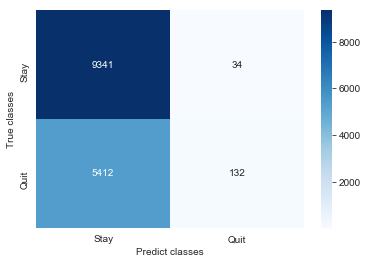

In [40]:
# confusion matrix
plot_confusion_matrix(y_train,y_pred)

In [18]:
y_pred,y_prob = rf.predict(X_test),rf.predict_proba(X_test)

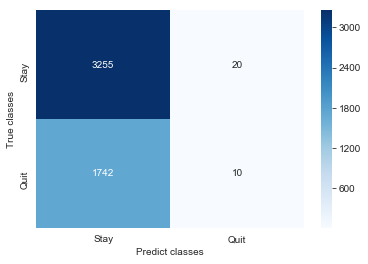

In [19]:
plot_confusion_matrix(y_test,y_pred)

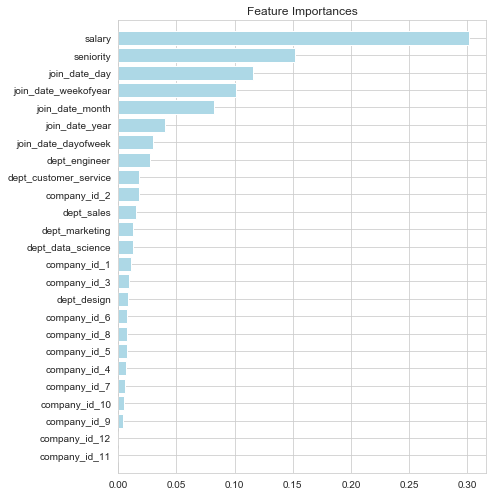

In [39]:
plot_feature_importances_rf(rf.feature_importances_,X.columns.values,figsize=(7,7))

# overfit model on entire dataset to get feature importance

In [41]:
rf = train_rf(X,y,X,y,{})

Train acc: 0.9717236538654367. Train lloss: 0.1997396135878689
Test acc: 0.9717236538654367. Test lloss: 0.1997396135878689


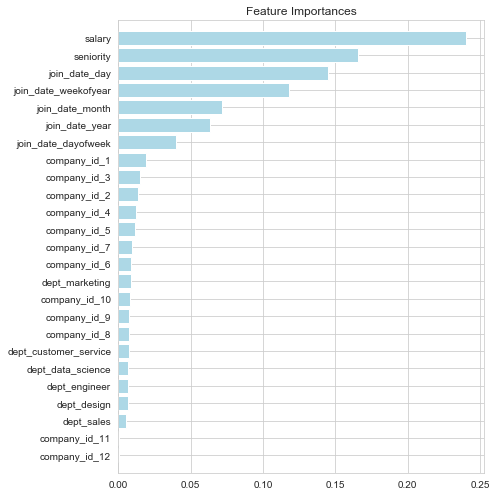

In [42]:
plot_feature_importances_rf(rf.feature_importances_,X.columns.values,figsize=(7,7))

Both models agree that salary and seniority are top 2 most important features. Few suggestions can be made:
- We can break down salary into bins (i.e low, medium, high) to see its effect on employee churn better. Same can be done for seniority
- How salary adjustment can change employee decision to stay or quit? (salary raise, better offer from other company ...)
- To build a better predictive model, we can include few more features that are related to time, such as: number of new employees per company/seniority/department from previous day/month/year (lag features) or even turnout rates from previous day/month/year. We can also experiment with other model such as logistic regression, GBM (though GBM might overfit easier for such small dataset)